# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from matching.cem import CEM
from util.fg_data import clean, get_data

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_palette('colorblind')
from datetime import datetime as dt

## Preprocessing

In [2]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   dist           18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [3]:
# df = pd.read_csv('../data/field_goals.csv', index_col=0)
# df.drop(['kicks','age','form'], axis=1, inplace=True)
# df.info()

## Variable of Interest

We filter for away kicks at altitude because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker?

In [4]:
# T = 'iced'
# drop = []

T = 'altitude'
drop = ['turf']
# df[on] = df[on].astype(bool)

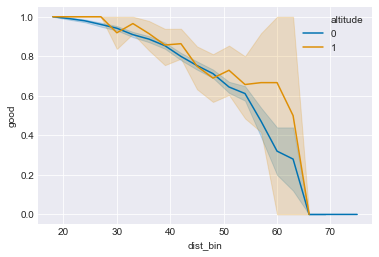

In [5]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue=T, data=df_)

In [6]:
print(df[T].value_counts())

0    18168
1      635
Name: altitude, dtype: int64


In [7]:
df

,good,dist,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,2000,17,22,0,10,1,0,0,1,0,1
2185,1,27,2000,17,22,0,10,1,0,0,1,0,1
4565,1,36,2000,17,26,0,13,0,0,1,0,0,5
8564,1,24,2000,17,16,0,16,1,0,0,1,1,1
8628,1,40,2000,17,16,0,16,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,30,2019,3,18,0,0,0,0,0,0,0,1
865338,1,21,2019,3,18,0,11,0,0,0,0,0,2
868268,1,22,2019,3,6,0,7,1,0,0,1,0,1


## One-to-many CEM with weighted linear regression - relaxed on distance
## k-k CEM with linear regression - relaxed on distance
## One-to-many CEM with weighted t-test / z-test (for altitude only on long range kicks?)
## k-k CEM with t-test / z-test (as above)
## One-to-many with Bayesian difference of means (May not be possible with beta-binomial conjugacy) (as above)
## k-k CEM with Bayesian difference of means (as above)

## Finding H for L1

In [8]:
continuous = ['dist', 'year', 'seasons', 'temperature', 'wind', 'pressure']

In [9]:
coarsening = {
    'dist': {'bins': 4, 'cut': 'cut'}, # relax over
    'year': {'bins': 4, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening.pop(T)
coarsening

{'dist': {'bins': 4, 'cut': 'cut'},
 'year': {'bins': 4, 'cut': 'cut'},
 'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'},
 'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [10]:
weights = CEM.match(df.drop('good', axis=1), T, coarsening)

Unable to allocate 6.87 GiB for an array with shape (10, 10, 10, 10, 10, 4, 4, 4, 4, 4, 9) and data type float64
11 11 11 Index(['dist', 'year', 'seasons', 'temperature', 'wind', 'away_game',
       'postseason', 'iced', 'turf', 'precipitation', 'pressure'],
      dtype='object')
Unable to allocate 6.87 GiB for an array with shape (10, 10, 10, 10, 10, 4, 4, 4, 4, 4, 9) and data type float64
11 11 11 Index(['dist', 'year', 'seasons', 'temperature', 'wind', 'away_game',
       'postseason', 'iced', 'turf', 'precipitation', 'pressure'],
      dtype='object')
Unable to allocate 11.1 GiB for an array with shape (11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 9) and data type float64
11 11 11 Index(['dist', 'year', 'seasons', 'temperature', 'wind', 'away_game',
       'postseason', 'iced', 'turf', 'precipitation', 'pressure'],
      dtype='object')
Unable to allocate 11.1 GiB for an array with shape (11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 9) and data type float64
11 11 11 Index(['dist', 'year', 'seasons', '

Text(0.5, 1.0, 'L1 score for different continuous binnings')

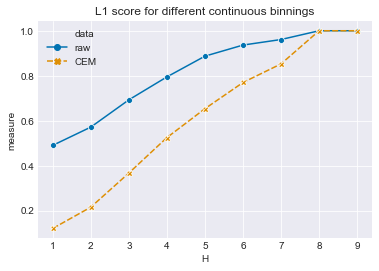

In [12]:
rows = []
cont_bins = range(1,10)
for H in cont_bins:
    # we use H bins for continuous variables when evaluating imbalance
    original_imbalance, (bins, ranges) = CEM.imbalance(df.drop('good', axis=1), T, continuous=continuous, H=H, retargs=True)
    rows.append(pd.Series({'data':'raw', 'measure':original_imbalance, 'H': H}))
    cem_imbalance = CEM.imbalance(df.drop('good', axis=1).loc[weights>0, :], T, bins=bins, ranges=ranges) # same bins and ranges as raw data histogram
    rows.append(pd.Series({'data':'CEM', 'measure':cem_imbalance, 'H': H}))
imbalance = pd.DataFrame.from_records(rows)
ax = sns.lineplot(x='H', y='measure', hue='data', data=imbalance, markers=True, style='data')
ax.set_title('L1 score for different continuous binnings')

H as 5 looks like a reasonable choice. We set this as the default in the function itself.

## L1 for depth>1 and one-to-many

In [10]:
coarsening = {
    'dist': {'bins': range(20,22), 'cut': 'cut'},
    'year': {'bins': range(3,4), 'cut': 'cut'},
    'seasons': {'bins': range(3,4), 'cut': 'qcut'},
    'temperature': {'bins': range(2,4), 'cut': 'qcut'},
    'wind': {'bins': range(3,4), 'cut': 'cut'},
    'pressure': {'bins': range(2,4), 'cut': 'cut'},
    'postseason': {'bins': range(2,3), 'cut': 'cut'},
    'iced': {'bins': range(2,3), 'cut': 'cut'},
    'precipitation': {'bins': range(2,3), 'cut': 'cut'},
    'altitude': {'bins': range(2,3), 'cut': 'cut'},
    'turf': {'bins': range(2,3), 'cut': 'cut'},
    'away_game': {'bins': range(2,3), 'cut': 'cut'},
    'altitude': {'bins': range(2,3), 'cut': 'cut'},
}

L1_results = CEM.relax(df.drop('good', axis=1), T, coarsening, continuous=continuous)

100%|██████████| 8/8 [01:08<00:00,  8.57s/it]


In [11]:
L1_results

,imbalance,coarsening,bins,treatment_0,treatment_1
0,0.674865,"{'dist': {'bins': 20, 'cut': 'cut'}, 'year': {...",138240,3745,547
1,0.674162,"{'dist': {'bins': 20, 'cut': 'cut'}, 'year': {...",207360,3739,545
2,0.681597,"{'dist': {'bins': 20, 'cut': 'cut'}, 'year': {...",207360,2872,528
3,0.680711,"{'dist': {'bins': 20, 'cut': 'cut'}, 'year': {...",311040,2865,526
4,0.664611,"{'dist': {'bins': 21, 'cut': 'cut'}, 'year': {...",145152,3643,540
5,0.663534,"{'dist': {'bins': 21, 'cut': 'cut'}, 'year': {...",217728,3632,538
6,0.666455,"{'dist': {'bins': 21, 'cut': 'cut'}, 'year': {...",217728,2882,517
7,0.665093,"{'dist': {'bins': 21, 'cut': 'cut'}, 'year': {...",326592,2872,514


In [ ]:
# TODO: Plot % matched vs coarsenings with L1 as an annotation

## L1 for depth=1 and one-to-many

In [13]:
coarsening = {
    'dist': {'bins': 4, 'cut': 'cut'}, # relax over
    'year': {'bins': 4, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening.pop(T)
coarsening

{'dist': {'bins': 4, 'cut': 'cut'},
 'year': {'bins': 4, 'cut': 'cut'},
 'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'},
 'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [14]:
weights = CEM.match(df.drop('good', axis=1), T, coarsening)

In [11]:
# TODO: Plot % matched vs coarsenings with L1 as an annotation

In [16]:
# TODO: Univariate imbalance dataframe for difference coarsenings
params = CEM.get_imbalance_params(df.drop(['good', T], axis=1), 'l1', continuous=continuous) # prior to matching
bins, ranges = params['bins'], params['ranges']
uni_imb = CEM.univariate_imbalance(df.drop('good', axis=1).loc[weights>0, :], T, measure='l1', bins=bins, ranges=ranges) # matched data using same imbalance coarsening
uni_imb

,imbalance,measure,statistic,type,min,max
dist,0.069012,l1,None,None,None,None
year,0.049375,l1,None,None,None,None
seasons,0.064321,l1,None,None,None,None
temperature,0.110035,l1,None,None,None,None
wind,0.151504,l1,None,None,None,None
away_game,0.074567,l1,None,None,None,None
postseason,0.018676,l1,None,None,None,None
iced,0.063275,l1,None,None,None,None
turf,0.000000,l1,None,None,None,None
precipitation,0.002385,l1,None,None,None,None


In [ ]:
# TODO: Plot marginal distributions for different coarsenings
from matching.cem import marginals
marginals(df.loc[weights > 0, :], treatment=T, kde=False, hist=True, n_bins=5)

## Weighted log-linear regression at different coarsenings

Distance is the most important covariate, so we will perform CEM for different level of distance coarsening and regress on the weighted results. We plot the evolution of the regression coefficients for each binning on distance.

In [21]:
bins = {
    'dist': {'bins': range(2, 11), 'cut': 'cut'}, # relax over
    'year': {'bins': 5, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
bins.pop(T)
bins

{'dist': {'bins': range(2, 11), 'cut': 'qcut'},
 'year': {'bins': 4, 'cut': 'cut'},
 'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'},
 'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [22]:
#model
formula = 'good ~ ' + ' + '.join(df.drop(['good']+drop, axis=1).columns) + f' + dist*{T}'
summary = CEM.regress(df, T, 'good', bins, formula=formula, drop=drop, continuous=continuous)

0%|          | 0/9 [00:00<?, ?it/s]Regressing with 9 different pd.qcut binnings on "dist"

100%|██████████| 9/9 [00:51<00:00,  5.77s/it]


In [23]:
summary.coarsenings()

,imbalance,observations,treatment_0,treatment_1
n_bins,,,,
2,0.681624,4216.0,3677.0,539.0
3,0.656405,3585.0,3069.0,516.0
4,0.667001,3211.0,2712.0,499.0
5,0.664732,2830.0,2343.0,487.0
6,0.653239,2612.0,2139.0,473.0
7,0.647146,2441.0,1980.0,461.0
8,0.640761,2231.0,1779.0,452.0
9,0.655318,2108.0,1662.0,446.0
10,0.661127,1961.0,1529.0,432.0


In [24]:
summary.covariates().loc[[T,f'dist:{T}'], :]

,,,coef,std err,z,P>|z|,[0.025,0.975]
covariate,n_bins,var,,,,,,
altitude,2,dist,0.3200,0.839,0.381,0.703,-1.325,1.965
dist:altitude,2,dist,0.0044,0.018,0.245,0.807,-0.031,0.040
altitude,3,dist,0.6987,0.869,0.805,0.421,-1.004,2.401
dist:altitude,3,dist,-0.0108,0.019,-0.569,0.569,-0.048,0.026
altitude,4,dist,1.2282,0.863,1.423,0.155,-0.463,2.920
dist:altitude,4,dist,-0.0210,0.019,-1.112,0.266,-0.058,0.016
altitude,5,dist,-0.7994,0.693,-1.154,0.249,-2.157,0.559
dist:altitude,5,dist,0.0181,0.016,1.151,0.250,-0.013,0.049
altitude,6,dist,0.4934,0.817,0.604,0.546,-1.107,2.094


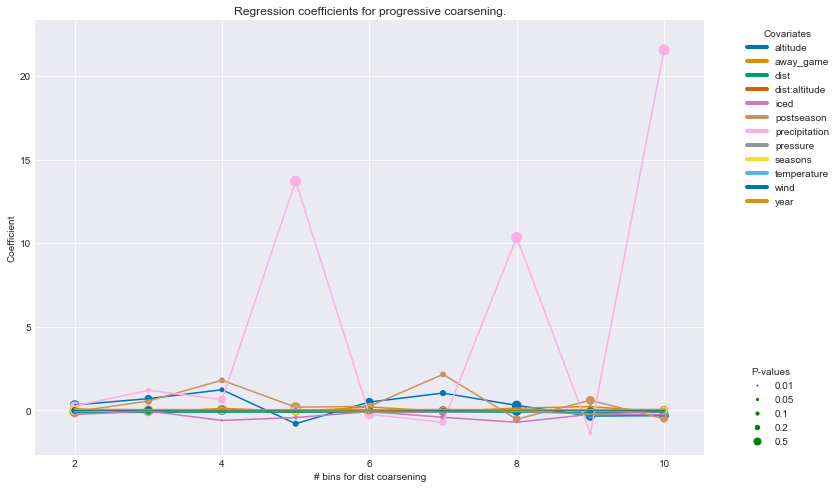

In [25]:
summary.plot(stars=False)

## Weighted difference of means (altitude: for short, medium and long and all-combined groups)

In [ ]:
from matching.cem import LSATT
weights = CEM.match(df.drop('good', axis=1), T, bins)
lsatt = LSATT(df, T, 'good', weights)
print(lsatt)

## k-k log-linear regression at different coarsenings

## k-k difference of means at different coarsenings (altitude: for short, medium and long and all-combined groups)

## k-k Bayesian difference of means at different coarsenings (altitude: for short, medium and long and all-combined groups)

## Model - BOGUS: This kind of modelling doesn't take into account stratum sizes. Will need to weight them if you want to use it.

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

In [ ]:
# dist_level = (df_matched['dist']>=40) & (df_matched['dist']<50)
dist_level = (df_matched['dist']>=45)
print(len(df_matched.loc[(df_matched[on]==1) & dist_level, :]), on, len(df_matched.loc[(df_matched[on]==0) & dist_level, :]), f'not {on}.')

In [ ]:
from scipy.stats import beta
p_hat = df_matched.loc[dist_level, 'good'].mean()
alpha_ = 10
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

In [ ]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, f'not {on}')
treatment = BetaBinomial(alpha_, beta_, on)
control.plot_prior(show=True)
plt.cla()

control.observe(df_matched.loc[(df_matched[on]==0) & dist_level, 'good'])
treatment.observe(df_matched.loc[(df_matched[on]==1) & dist_level, 'good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_c = control.sample(samples)
samples_posterior_t = treatment.sample(samples)

In [ ]:
posterior_diff = samples_posterior_t - samples_posterior_c

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_t>samples_posterior_c).mean()*100)
print(f'{gt}% likely that {on} has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment over control using our posterior distributions.

In [ ]:
posterior_relative = (samples_posterior_t-samples_posterior_c)/samples_posterior_c
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title(f'Posterior distribution of relative lift for {on} kicks over not-{on} kicks.')
print(int((posterior_relative>0.05).mean()*100), r'% likely relative lift is greater than 5%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')